### Load Fitness Data

In [526]:
import pyreadr
import pandas as pd
import os

data = pyreadr.read_r('code_analyses_figures/in_data/fitness_data_wt.rds') # Path to fitness data
data = data[None]
data.to_csv('fitness_data.csv')

/opt/homebrew/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2320: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [527]:
nucleotides = ['A', 'T', 'G', 'C']
# original_sequence = list("AATGAACGG") # -0.0003
# original_sequence = list(data['SV'][0]) # original 0.0000
# original_sequence = list("TAGGACTCG") # 0.0001
# original_sequence = list("GCGGACCTG") # 0.0006
original_sequence = list("CGCGAGAGG") # 0.0006

print("No mutation:", "".join(original_sequence))
os.makedirs("".join(original_sequence), exist_ok=True)

No mutation: CGCGAGAGG


In [528]:
def get_epistasis(f_a, f_b, f_ab):
    if(abs(f_ab - (f_a + f_b)) < 0.025):
        epistasis = 'No'
    elif(f_a*f_b<0 and f_ab > max(f_a, f_b)):
        epistasis = 'Single Sign'
    elif(f_a*f_b>0 and f_a*f_ab<0):
        epistasis = 'Reciprocal Sign'
    elif(f_ab<f_a+f_b):
        epistasis = 'Negative'
    else:
        epistasis = 'Positive'
    return epistasis

### Analyse all double mutations
Get fitness for all tuples (A,B,AB)<br>
Number of possible pairs = <sup>9</sup>C<sub>2</sub>\*3\*3 = 324

In [529]:
import itertools
pair_fitnesses = pd.DataFrame(columns=['Mutant_A', 'Mutant_B', 'Fitness_A', 'Fitness_B', 'Fitness_AB', 'Epistasis'])
position_pairs = []

for i1 in range(9):
    for i2 in range(i1+1,9):
        position_pairs.append((i1,i2,))

incomplete_data = 0
for (i1,i2) in position_pairs:
    for (m1, m2) in itertools.product(nucleotides, nucleotides):
        if(m1 == original_sequence[i1] or m2 == original_sequence[i2]):
            continue

        mutant_a = list(original_sequence)
        mutant_a[i1] = m1
        mutant_a = "".join(mutant_a)

        mutant_b = list(original_sequence)
        mutant_b[i2] = m2
        mutant_b = "".join(mutant_b)

        mutant_ab = list(original_sequence)
        mutant_ab[i1] = m1
        mutant_ab[i2] = m2
        mutant_ab = "".join(mutant_ab)

        f_a = data.loc[data['SV'] == mutant_a]['m']
        if(len(f_a.array)>0):
            f_a = f_a.array[0]
        else:
            f_a = None
        f_b = data.loc[data['SV'] == mutant_b]['m']
        if(len(f_b.array)>0):
            f_b = f_b.array[0]
        else:
            f_b = None
        f_ab = data.loc[data['SV'] == mutant_ab]['m']
        if(len(f_ab.array)>0):
            f_ab = f_ab.array[0]
        else:
            f_ab = None

        if(f_a == None or f_b == None or f_ab == None):
            incomplete_data += 1
            continue

        epistasis = get_epistasis(f_a, f_b, f_ab)
        pair_fitnesses = pd.concat([pd.DataFrame([[mutant_a, mutant_b, f_a, f_b, f_ab, epistasis]], columns=pair_fitnesses.columns), pair_fitnesses], ignore_index=True)

pair_fitnesses.to_csv(f'{"".join(original_sequence)}/pair_epistatis.csv')
print("Tuples with missing data:", incomplete_data)
            

Tuples with missing data: 2


### Count Frequencies
of the different types of epistasis

In [530]:
epistasis_types = ["Positive", "Negative", "No", "Single Sign", "Reciprocal Sign"]
total = len(pair_fitnesses)
single_sign_epistasis = len(pair_fitnesses.loc[pair_fitnesses['Epistasis'] == 'Single Sign'])
reciprocal_sign_epistasis = len(pair_fitnesses.loc[pair_fitnesses['Epistasis'] == 'Reciprocal Sign'])
no_epistasis = len(pair_fitnesses.loc[pair_fitnesses['Epistasis'] == 'No'])
positive_epistasis = len(pair_fitnesses.loc[pair_fitnesses['Epistasis'] == 'Positive'])
negative_epistasis = len(pair_fitnesses.loc[pair_fitnesses['Epistasis'] == 'Negative'])
print("no_epistatis", "positive_epistasis", "negative_epistasis", "single_sign_epistasis", "reciprocal_sign_epistatis")
print(no_epistasis, positive_epistasis, negative_epistasis, single_sign_epistasis, reciprocal_sign_epistasis)
print(no_epistasis/total, positive_epistasis/total, negative_epistasis/total, single_sign_epistasis/total, reciprocal_sign_epistasis/total)

no_epistatis positive_epistasis negative_epistasis single_sign_epistasis reciprocal_sign_epistatis
26 105 160 20 11
0.08074534161490683 0.32608695652173914 0.4968944099378882 0.062111801242236024 0.034161490683229816


### For background Mutant X
(9-2)\*3 = 21 Possibilities for each pair (A,B)

In [531]:
single_mutants = [(-1,"".join(original_sequence))]
columns = ['Mutant_A', 'Mutant_B', 'NM']
for i in range(9):
    for n in nucleotides:
        if(n == original_sequence[i]):
            continue
        mutant = list(original_sequence)
        mutant[i] = n
        single_mutants.append((i,"".join(mutant),))
        columns.append("".join(mutant))

# Fitness of X Mutants
x_fit = {}
for i, mutant in single_mutants:
    f = data.loc[data['SV'] == mutant]['m'].array
    if(len(f)==0):
        x_fit[mutant] = None
    else:
        x_fit[mutant] = f[0]

epistasis_nature = pd.DataFrame(columns=columns)
for (i1,i2) in position_pairs:
    for (m1, m2) in itertools.product(nucleotides, nucleotides):
        if(m1 == original_sequence[i1] or m2 == original_sequence[i2]):
            continue
        mutant_a = list(original_sequence)
        mutant_a[i1] = m1
        mutant_a = "".join(mutant_a)

        mutant_b = list(original_sequence)
        mutant_b[i2] = m2
        mutant_b = "".join(mutant_b)

        row = [mutant_a, mutant_b]
        for (i,x_mutant) in single_mutants:
            f_0 = x_fit[x_mutant]
            if(f_0==None):
                row.append(None)
                continue
            if(i==i1 or i==i2):
                row.append(None)
                continue

            mutant_xa = list(x_mutant)
            mutant_xa[i1] = m1
            mutant_xa = "".join(mutant_xa)

            mutant_xb = list(x_mutant)
            mutant_xb[i2] = m2
            mutant_xb = "".join(mutant_xb)

            mutant_xab = list(x_mutant)
            mutant_xab[i1] = m1
            mutant_xab[i2] = m2
            mutant_xab = "".join(mutant_xab)

            f_a = data.loc[data['SV'] == mutant_xa]['m']
            if(len(f_a.array)>0):
                f_a = f_a.array[0] - f_0
            else:
                f_a = None
            f_b = data.loc[data['SV'] == mutant_xb]['m']
            if(len(f_b.array)>0):
                f_b = f_b.array[0] - f_0
            else:
                f_b = None
            f_ab = data.loc[data['SV'] == mutant_xab]['m']
            if(len(f_ab.array)>0):
                f_ab = f_ab.array[0] - f_0
            else:
                f_ab = None

            if(f_a == None or f_b == None or f_ab == None):
                row.append(None)
                continue

            epistasis = get_epistasis(f_a, f_b, f_ab)
            row.append(epistasis)
            
        epistasis_nature = pd.concat([pd.DataFrame([row], columns=epistasis_nature.columns), epistasis_nature], ignore_index=True)

epistasis_nature.to_csv(f'{"".join(original_sequence)}/xab.csv')

### Change Analysis

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


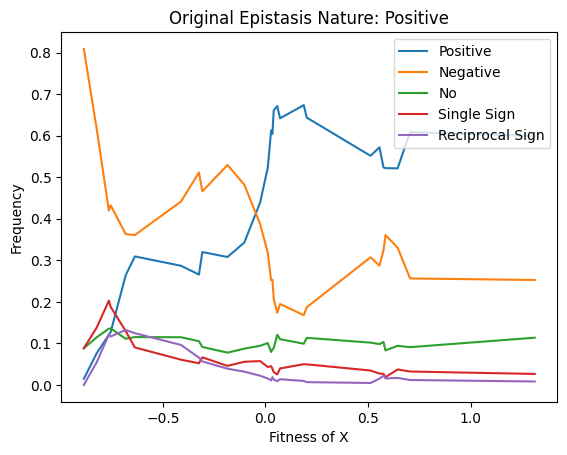

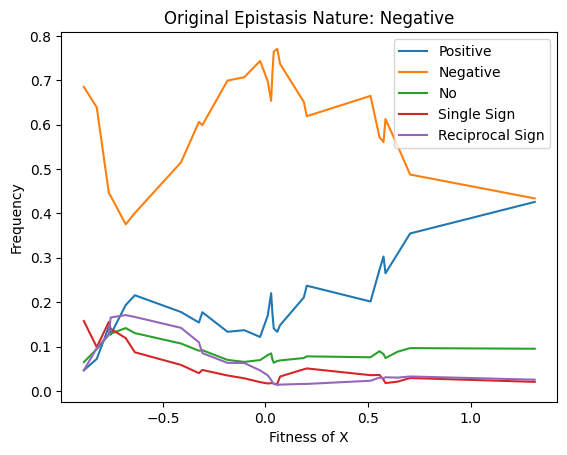

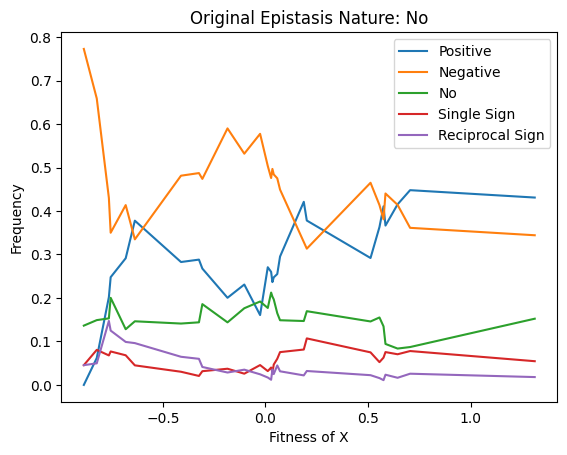

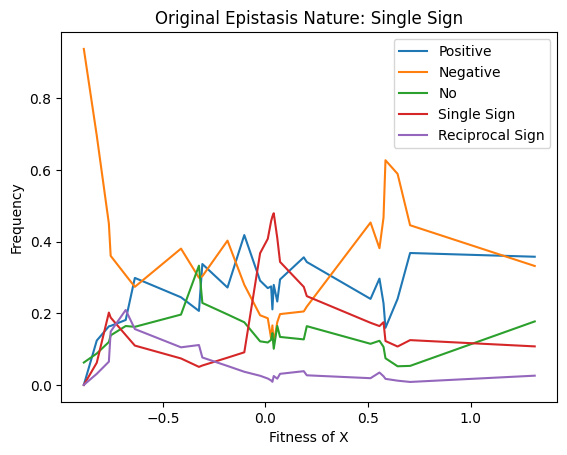

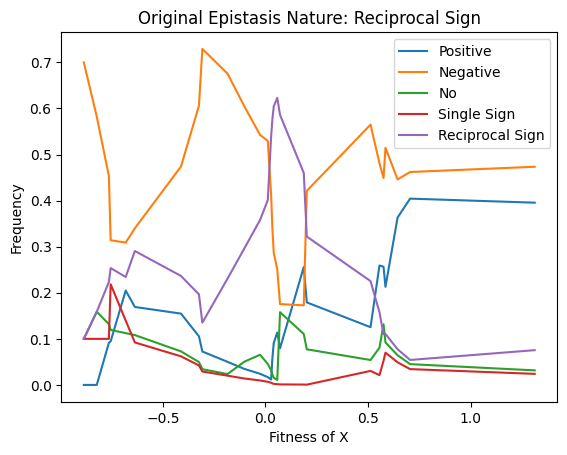

In [532]:
import matplotlib.pyplot as plt
import numpy as np

# Change wrt earlier epistasis type

fitness_x = []

for i, mutant in single_mutants[1:]:
    f_x = x_fit[mutant]
    if(f_x == None):
        continue
    for index, row in epistasis_nature.iterrows():
        if(row['NM']==None or row[mutant]==None):
            continue
        fitness_x.append([row['NM'], mutant, row[mutant]])

# Given earlier epistasis type, plot new type v/s fitness
fitness_x = np.array(fitness_x)
plot_data = {x:{} for x in epistasis_types}
for r in fitness_x:
    if(r[1] in plot_data[r[0]]):
        plot_data[r[0]][r[1]][r[2]] += 1
    else:
        plot_data[r[0]][r[1]] = {x:0 for x in epistasis_types}
file_out = open(f'{"".join(original_sequence)}/change_orig_fitness.txt', 'w')
range1 = list(np.arange(-1,1.1,0.2))
ranges = [(range1[i],range1[i+1]) for i in range(len(range1)-1)]
x_vals = []
for range_start, range_end in ranges:
    x_vals.append((range_start + range_end)/2)
x_vals = [ round(elem, 2) for elem in x_vals ]
file_out.write('mean fitness'.ljust(20) + str(x_vals) + '\n')
for k1 in plot_data:
    file_out.write('\nOriginally ' + str(k1) + '\n')
    single_plot_data = plot_data[k1]
    f_list = []
    epistasis_type_fraction = {x:[] for x in epistasis_types}
    for mt in single_plot_data:
        f_list.append(x_fit[mt])
        n_samples = sum(list(single_plot_data[mt].values()))
        for k2 in single_plot_data[mt]:
            epistasis_type_fraction[k2].append(single_plot_data[mt][k2]/(n_samples+1e-12))
    f_list_sort = sorted(f_list.copy())
    for (i,k2) in enumerate(epistasis_type_fraction.keys()):
        x_v, y_v = (list(t) for t in zip(*sorted(zip(f_list.copy(), epistasis_type_fraction[k2].copy()))))
        y_vals = []
        for range_start, range_end in ranges:
            indices = np.where((np.array(x_v) >= range_start) & (np.array(x_v) < range_end))
            mean_y = np.mean([y_v[i] for i in indices[0]])
            y_vals.append(mean_y)  
        y_vals = [ round(elem, 2) for elem in y_vals ]
        file_out.write(str(k2).ljust(20)+str(y_vals)+'\n')
        y_v = pd.Series(y_v).ewm(alpha=0.3).mean()
        plt.plot(x_v, y_v, label=k2)
    plt.ylabel('Frequency')
    plt.xlabel("Fitness of X")
    plt.title(f'Original Epistasis Nature: {k1}')
    plt.legend()
    plt.savefig(f'{"".join(original_sequence)}/change_orig_fitness_{k1}.png')
    plt.show()
    plt.close()
file_out.close()

### Additional Analysis

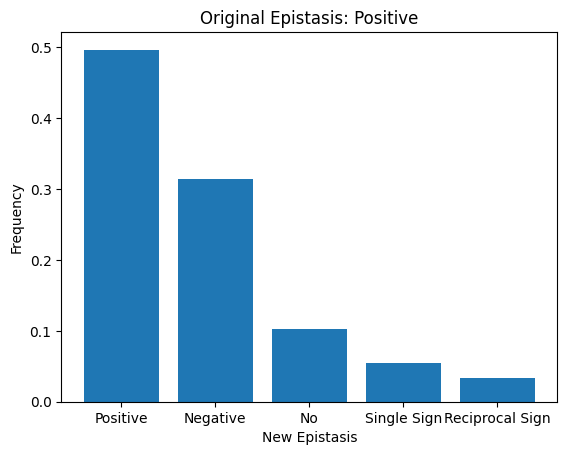

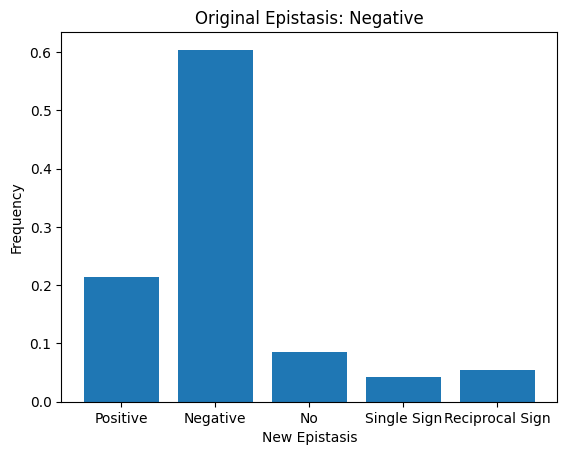

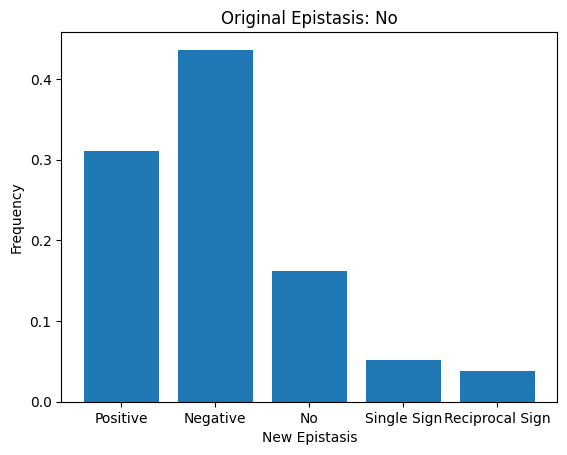

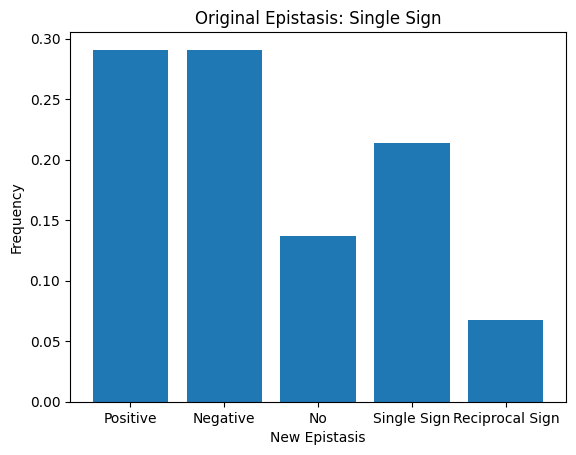

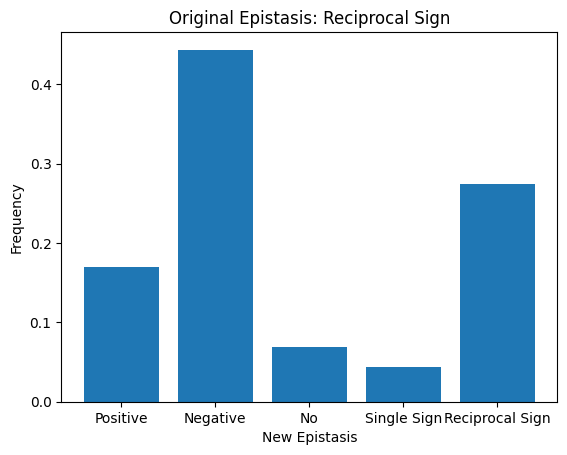

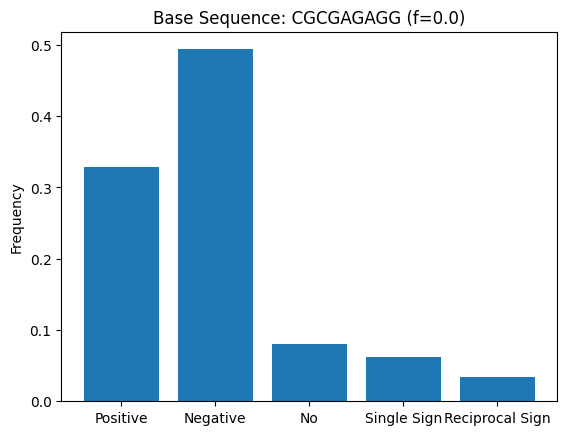

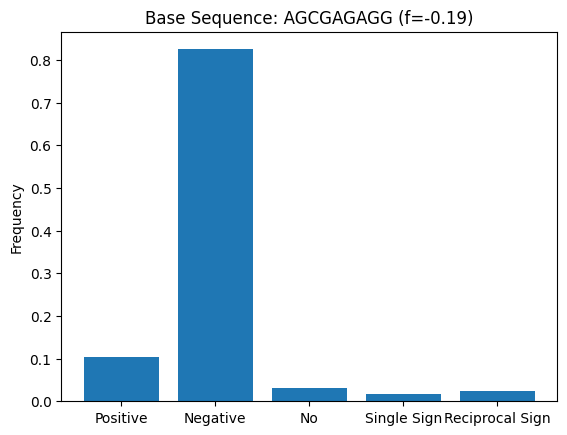

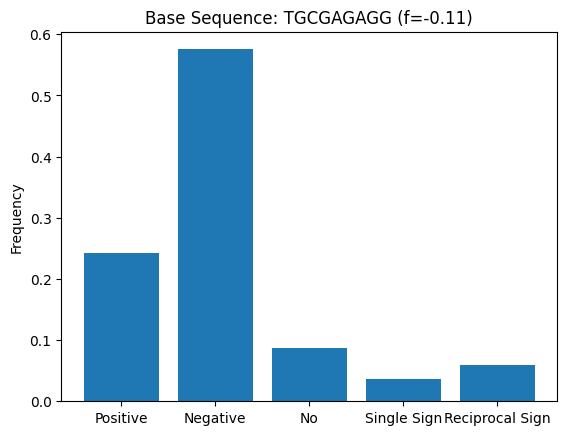

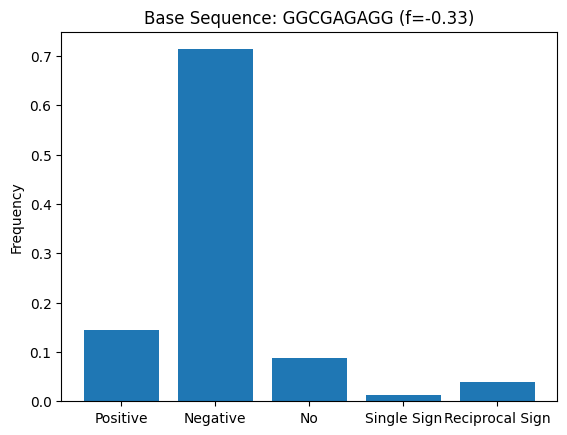

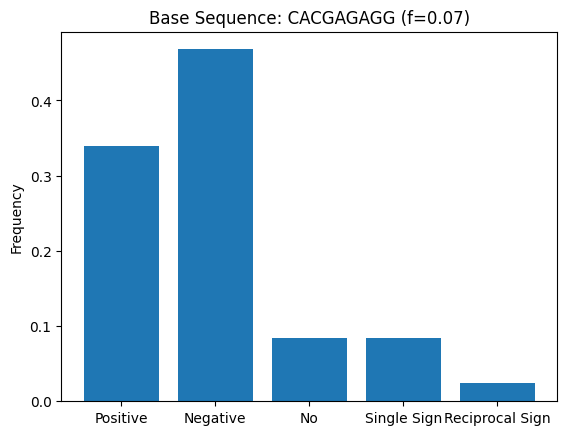

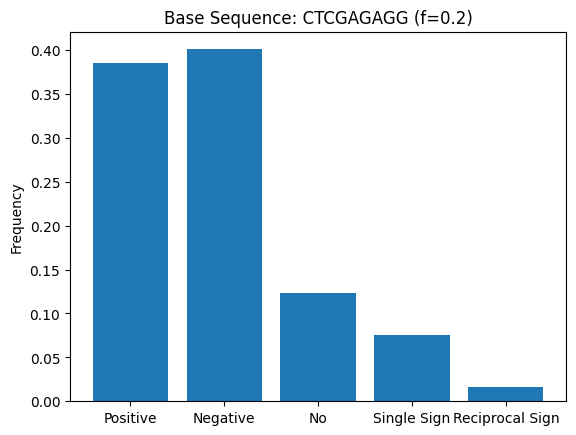

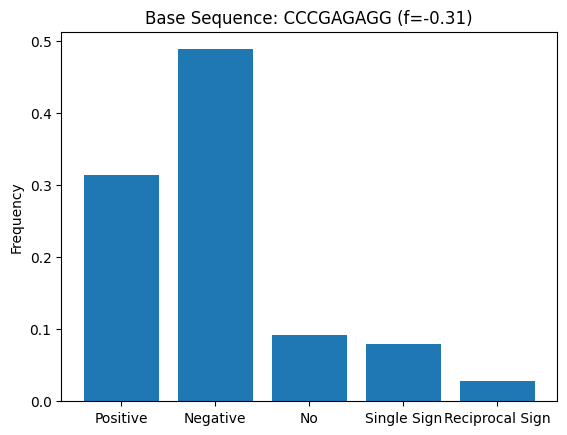

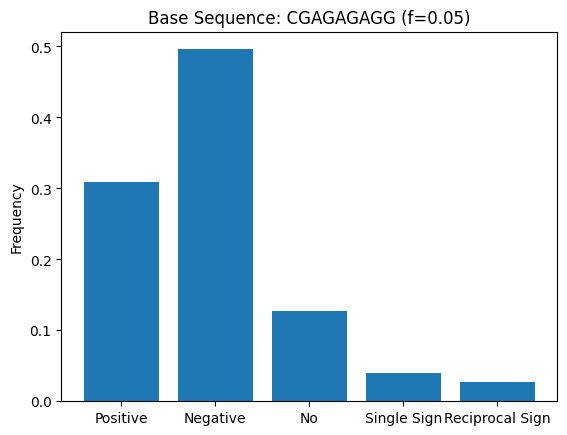

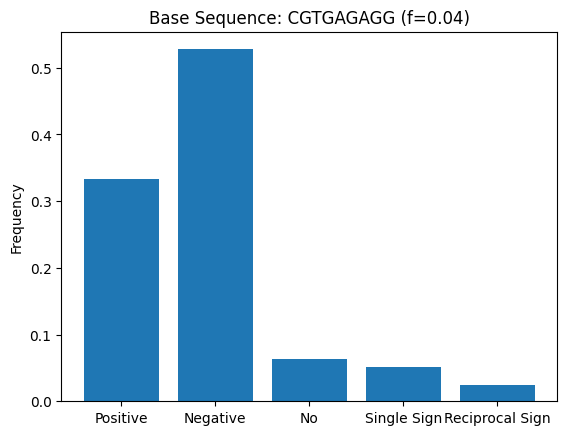

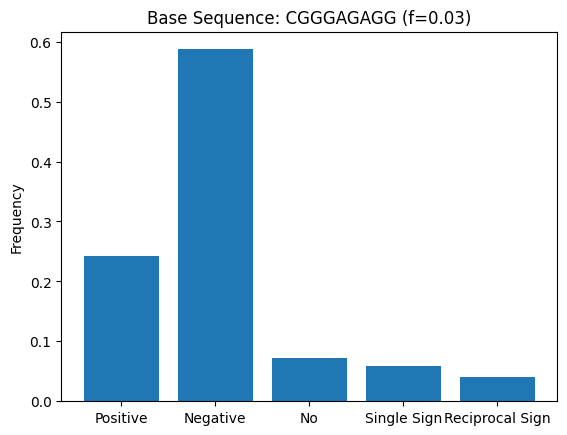

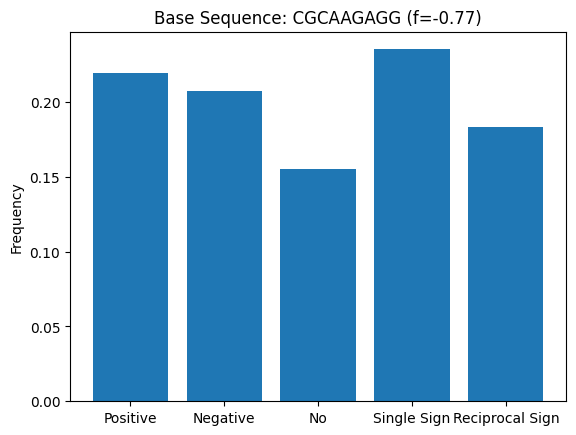

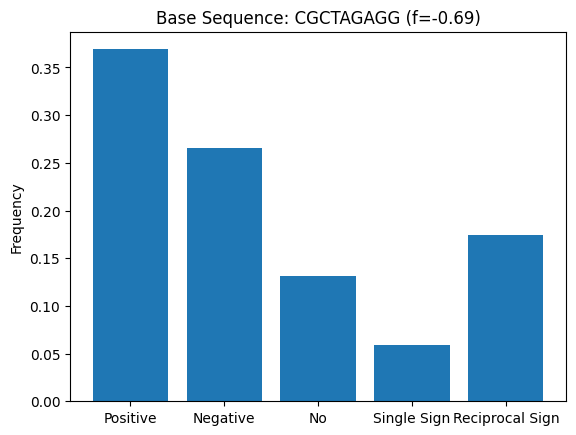

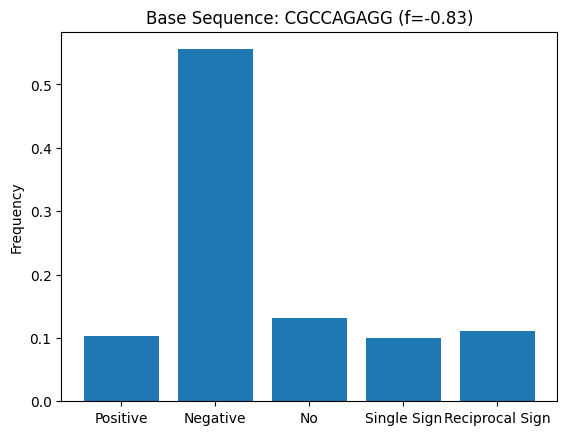

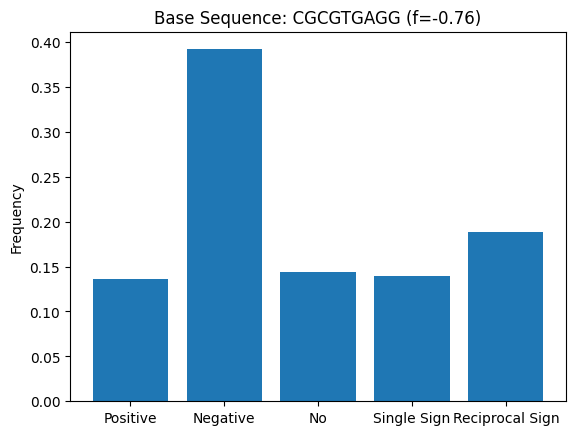

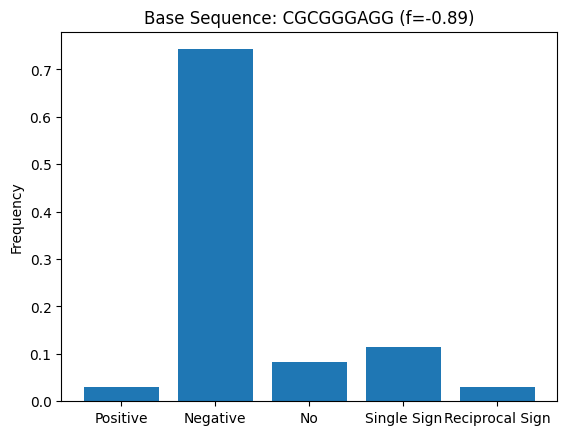

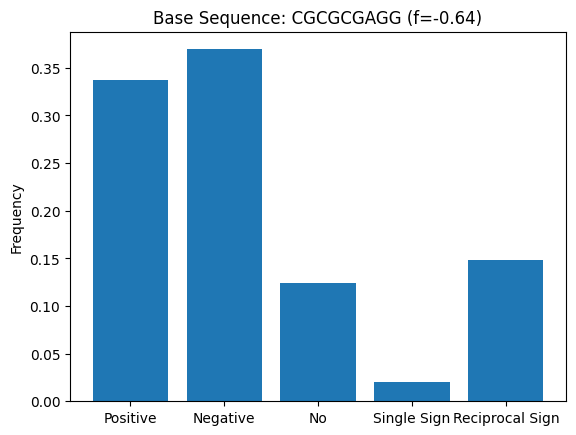

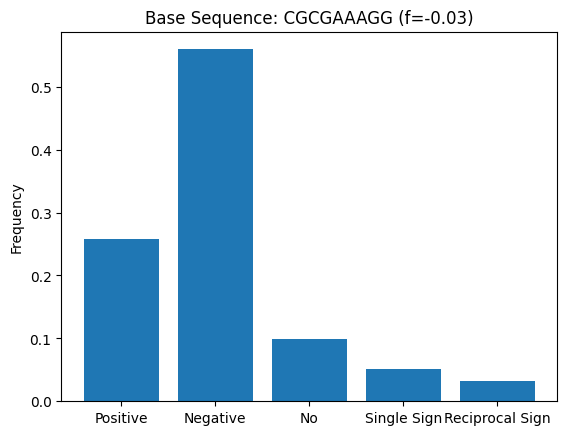

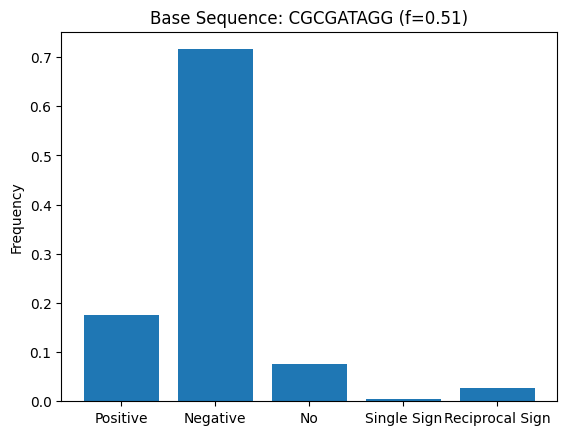

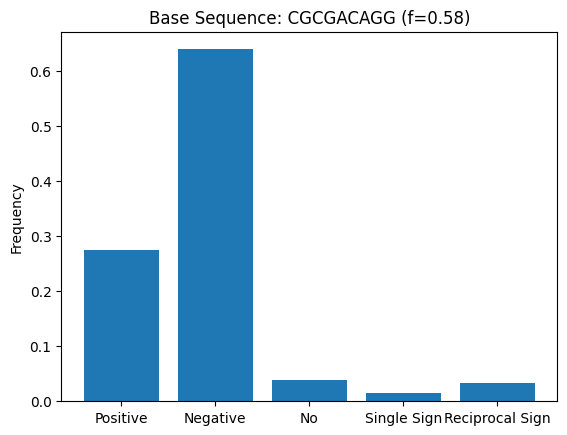

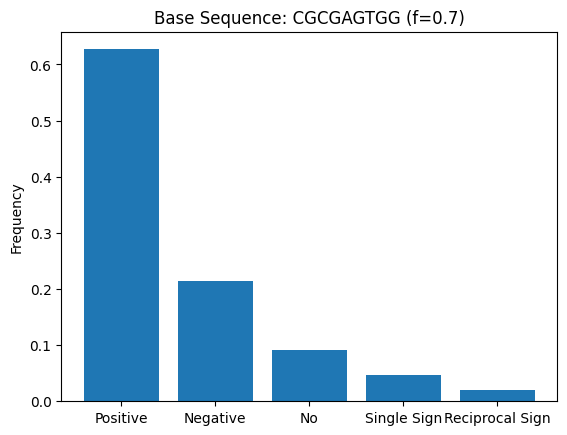

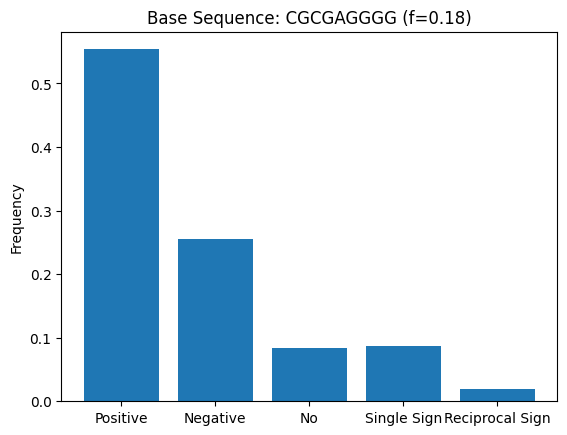

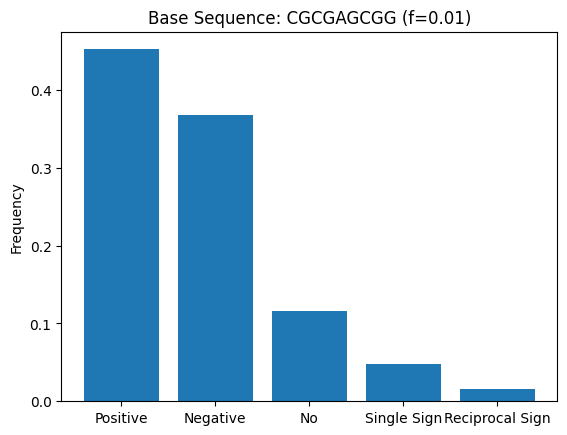

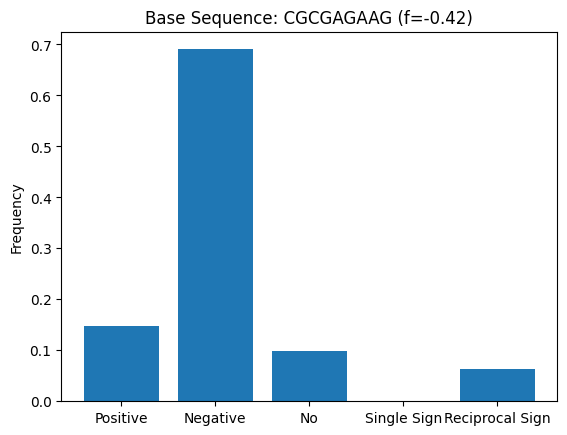

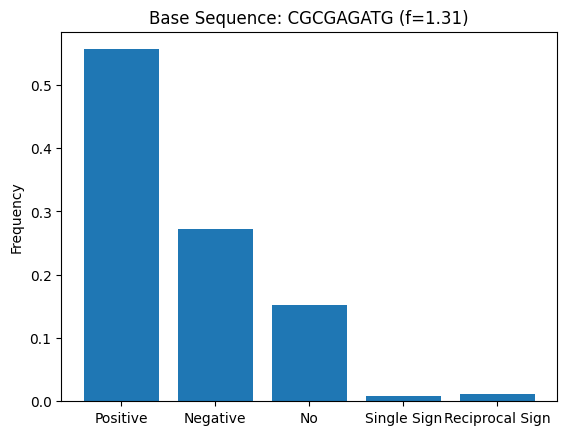

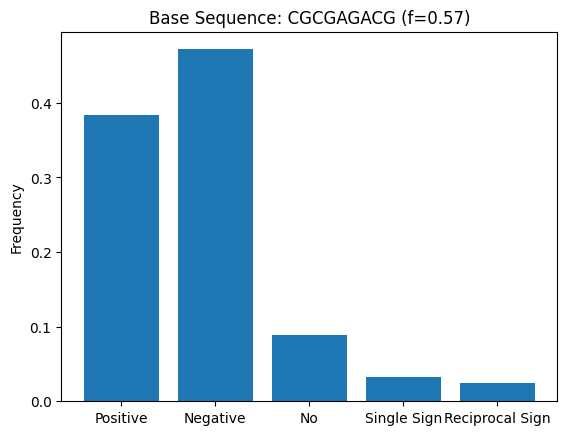

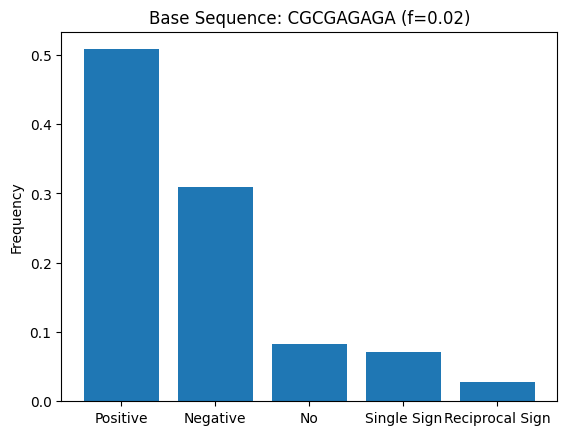

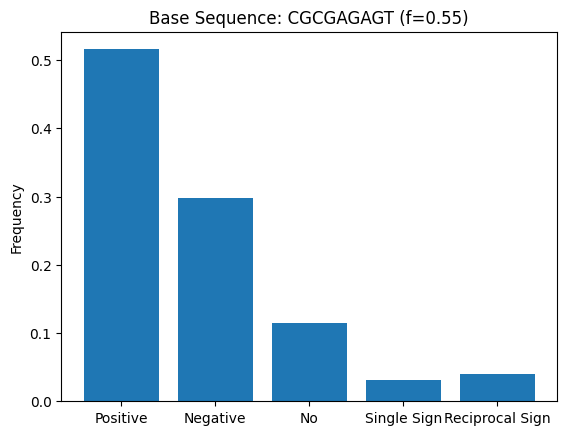

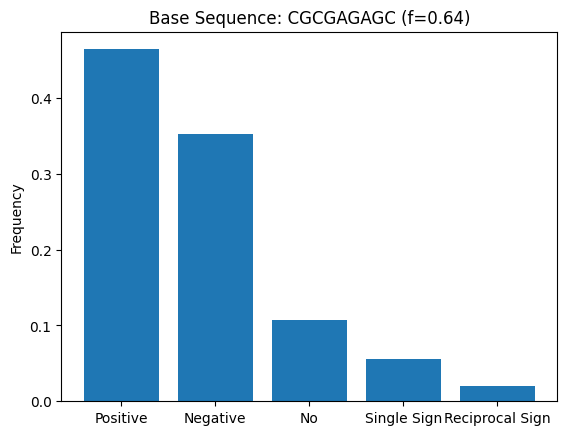

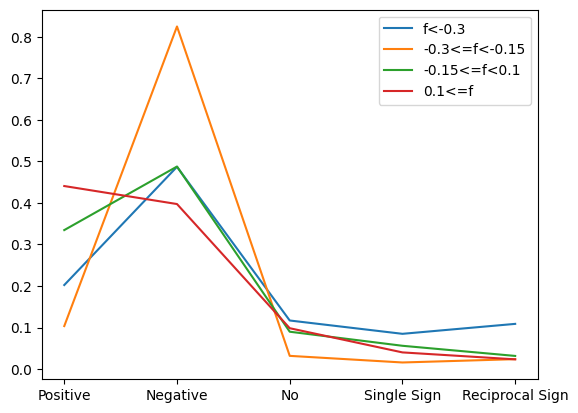

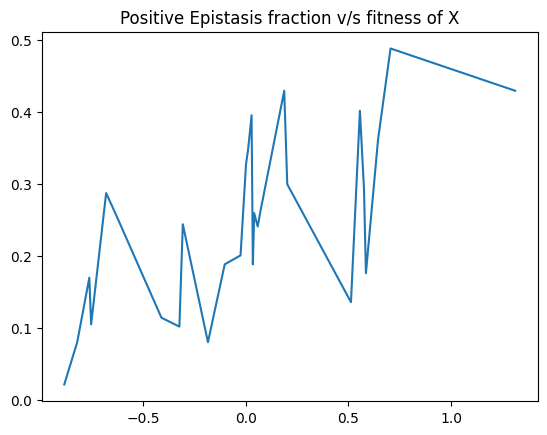

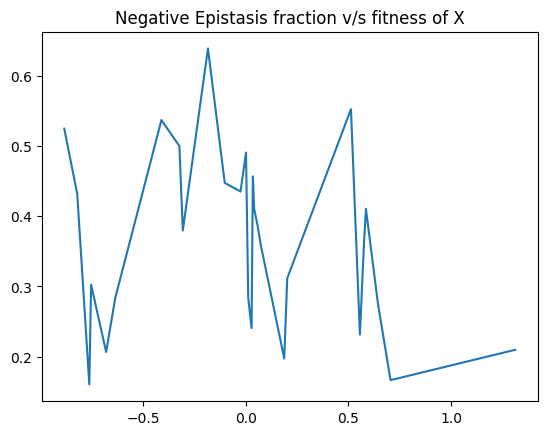

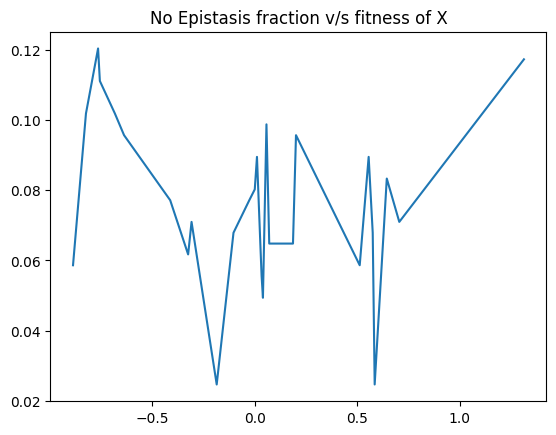

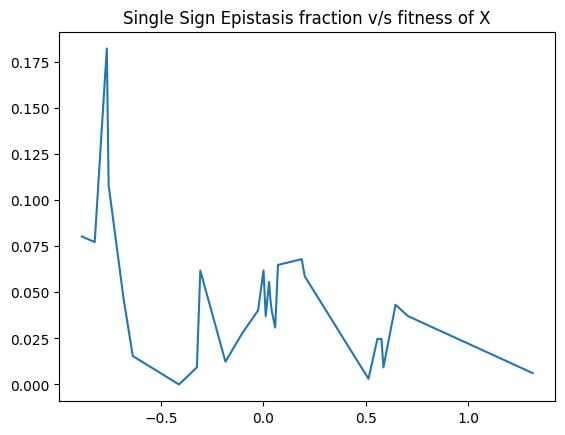

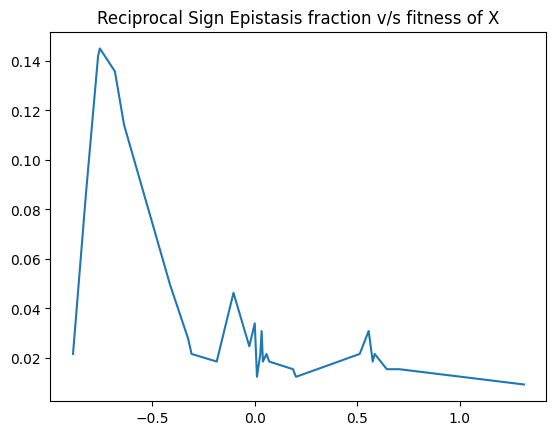

In [533]:
import matplotlib.pyplot as plt
import numpy as np

change = {"Positive": {"Positive": 0, "Negative": 0, "No": 0, "Single Sign": 0, "Reciprocal Sign": 0}, 
          "Negative": {"Positive": 0, "Negative": 0, "No": 0, "Single Sign": 0, "Reciprocal Sign": 0}, 
          "No": {"Positive": 0, "Negative": 0, "No": 0, "Single Sign": 0, "Reciprocal Sign": 0}, 
          "Single Sign": {"Positive": 0, "Negative": 0, "No": 0, "Single Sign": 0, "Reciprocal Sign": 0}, 
          "Reciprocal Sign": {"Positive": 0, "Negative": 0, "No": 0, "Single Sign": 0, "Reciprocal Sign": 0}}
change2 = {}
change3 = [{"Positive": 0, "Negative": 0, "No": 0, "Single Sign": 0, "Reciprocal Sign": 0},
           {"Positive": 0, "Negative": 0, "No": 0, "Single Sign": 0, "Reciprocal Sign": 0},
           {"Positive": 0, "Negative": 0, "No": 0, "Single Sign": 0, "Reciprocal Sign": 0},
           {"Positive": 0, "Negative": 0, "No": 0, "Single Sign": 0, "Reciprocal Sign": 0},]
for index, row in epistasis_nature.iterrows():
    for i, mutant in single_mutants[1:]:
        if(row['NM']==None or row[mutant]==None):
            continue
        change[row['NM']][row[mutant]] += 1
    for i, mutant in single_mutants:
        if(mutant == "".join(original_sequence)):
            mutant = 'NM'
        if(row[mutant]==None):
            continue
        if(mutant in change2 and row[mutant] in change2[mutant]):
            change2[mutant][row[mutant]] += 1
        elif(mutant in change2):
            change2[mutant][row[mutant]] = 1
        else:
            change2[mutant] = {"Positive": 0, "Negative": 0, "No": 0, "Single Sign": 0, "Reciprocal Sign": 0}
            change2[mutant][row[mutant]] = 1
    for i, mutant in single_mutants:
        f = x_fit[mutant]
        if(mutant == "".join(original_sequence)):
            mutant = 'NM'
        if(row[mutant]==None):
            continue
        if(f==None):
            continue

        if(f<-0.3):
            f_range = 0
        elif(f<-0.15):
            f_range = 1
        elif(f<0.1):
            f_range = 2
        else:
            f_range = 3
        
        change3[f_range][row[mutant]] += 1

# Change wrt earlier epistasis type
type_matrix = pd.DataFrame(columns = ["Old Type"] + epistasis_types)
for key in change:
    vals = np.array(list(change[key].values()))
    vals = vals/np.sum(vals)
    type_matrix = pd.concat([pd.DataFrame([[key] + list(vals)], columns=type_matrix.columns), type_matrix], ignore_index=True)
    plt.bar(range(len(change[key])), list(vals), align='center')
    plt.ylabel('Frequency')
    plt.xlabel('New Epistasis')
    plt.xticks(range(len(change[key])), list(change[key].keys()))
    plt.title(f"Original Epistasis: {key}")   
    plt.savefig(f'{"".join(original_sequence)}/change_{key}.png')
    plt.show()
    plt.close()
type_matrix.to_csv(f'{"".join(original_sequence)}/type_matrix.csv')


# Epistasis nature wrt X
for key in change2:
    vals = np.array(list(change2[key].values()))
    vals = vals/np.sum(vals)
    plt.bar(range(len(change2[key])), list(vals), align='center')
    plt.ylabel('Frequency')
    plt.xticks(range(len(change2[key])), list(change2[key].keys()))
    if(key=='NM'):
        key = "".join(original_sequence)
    f = x_fit[key]
    if(f!=None):
        f = ((f*100)//1)/100
    plt.title(f'Base Sequence: {key} (f={f})')   
    plt.savefig(f'{"".join(original_sequence)}/XAB_{key}.png')
    plt.show()
    plt.close()


    
# Epistasis Nature wrt Base Fitness
for (i,row) in enumerate(change3):
    if(i==0):
        label = ('f<-0.3')
    elif(i==1):
        label = ('-0.3<=f<-0.15')
    elif(i==2):
        label = ('-0.15<=f<0.1')
    elif(i==3):
        label = ('0.1<=f')
    vals = np.array(list(row.values()))
    vals = vals/np.sum(vals)
    plt.plot(range(len(row)), list(vals), label = label)
plt.xticks(range(len(change3[0])), list(change3[0].keys()))
plt.legend()
plt.savefig(f'{"".join(original_sequence)}/fitness.png')
plt.show()
plt.close()

# Percentage of each type wrt fitness
fitness = []
pos = []
neg = []
no = []
single = []
reci = []
for i, mutant in single_mutants:
    f = x_fit[mutant]
    if(mutant == "".join(original_sequence)):
        mutant = 'NM'
    if(f==None):
        continue
    fitness.append(f)
    mutant_data = epistasis_nature[mutant].to_list()
    pos.append(mutant_data.count('Positive')/len(mutant_data))
    neg.append(mutant_data.count('Negative')/len(mutant_data))
    no.append(mutant_data.count('No')/len(mutant_data))
    single.append(mutant_data.count('Single Sign')/len(mutant_data))
    reci.append(mutant_data.count('Reciprocal Sign')/len(mutant_data))
fitness, pos, neg, no, single, reci = (list(t) for t in zip(*sorted(zip(fitness, pos, neg, no, single, reci))))
plt.plot(fitness, pos)
plt.title('Positive Epistasis fraction v/s fitness of X')
plt.savefig(f'{"".join(original_sequence)}/fitness_positive.png')
plt.show()
plt.close()

plt.plot(fitness, neg)
plt.title('Negative Epistasis fraction v/s fitness of X')
plt.savefig(f'{"".join(original_sequence)}/fitness_negative.png')
plt.show()
plt.close()

plt.plot(fitness, no)
plt.title('No Epistasis fraction v/s fitness of X')
plt.savefig(f'{"".join(original_sequence)}/fitness_no.png')
plt.show()
plt.close()

plt.plot(fitness, single)
plt.title('Single Sign Epistasis fraction v/s fitness of X')
plt.savefig(f'{"".join(original_sequence)}/fitness_ss.png')
plt.show()
plt.close()

plt.plot(fitness, reci)
plt.title('Reciprocal Sign Epistasis fraction v/s fitness of X')
plt.savefig(f'{"".join(original_sequence)}/fitness_rs.png')
plt.show()
plt.close()